In [98]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
import seaborn as sns

In [99]:
plt.style.use("default")
sns.set_theme(
    context="paper",
    style="white",
    palette="icefire",
    font="serif",
    font_scale=1.5,
    color_codes=True,
    rc={"text.usetex": True},
)
os.makedirs("../figures/SCALING/", exist_ok=True)
fig_dir = "../figures/SCALING/"

In [100]:
def load_experiment_data(root_dir: str, lr: float = 0.001) -> pd.DataFrame:
    """Load experiment data from complex directory structure"""
    records = []
    root_path = Path(root_dir)

    # Find all terminal seed directories containing results
    for seed_dir in root_path.glob("**/seed=*/"):
        # Extract parameters from path components
        params = {
            "hidden_size": None,
            "dataset_size": None,
            "lr": None,
            "seed": int(seed_dir.name.split("=")[1]),
        }

        # Parse parameters from parent directories
        for parent in seed_dir.parents:
            if parent.name.startswith("hidden_size="):
                params["hidden_size"] = int(parent.name.split("=")[1])
            elif parent.name.startswith("dataset_size="):
                params["dataset_size"] = int(parent.name.split("=")[1])
            elif parent.name.startswith("lr="):
                params["lr"] = float(parent.name.split("=")[1])

        # Validate all parameters found
        if None in params.values():
            missing = [k for k, v in params.items() if v is None]
            print(f"Skipping {seed_dir} - missing: {missing}")
            continue

        try:
            # Load metrics files
            test_losses = np.loadtxt(seed_dir / "test_losses.txt")
            train_losses = np.loadtxt(seed_dir / "train_losses.txt")
            control = np.loadtxt(seed_dir / "controls.txt")
            epochs = np.loadtxt(seed_dir / "epochs.txt")

            records.append(
                {
                    **params,
                    "test_loss": test_losses,
                    "train_loss": train_losses,
                    "epoch": epochs,
                    "control": control,
                }
            )
        except Exception as e:
            print(f"Error loading {seed_dir}: {str(e)}")
            continue

    return pd.DataFrame(records)

In [101]:
growing_df = load_experiment_data("../output/bessel_regression/")
baseline_df = load_experiment_data("../output/bessel_regression_baseline/")

In [102]:
def calculate_mean_std_across_runs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the mean and standard deviation of array-valued columns
    across different runs, grouping by all *scalar* columns *except* the 'seed' column.
    """

    if "seed" not in df.columns:
        raise ValueError("DataFrame must contain a 'seed' column.")

    array_cols = [col for col in df.columns if isinstance(df[col].iloc[0], np.ndarray)]

    if not array_cols:
        raise ValueError("No array-valued columns found.")

    scalar_cols = [col for col in df.columns if col != "seed" and col not in array_cols]

    def mean(x: pd.Series) -> np.ndarray:
        """Calculates the mean array across runs."""
        return np.mean(np.stack(x.values), axis=0)

    def std(x: pd.Series) -> np.ndarray:
        """Calculates the standard deviation array across runs."""
        return np.std(np.stack(x.values), axis=0)

    grouped = df.groupby(scalar_cols)

    # Calculate the mean and std for each array-valued column
    agg_dict = {col: [mean, std] for col in array_cols}
    result = grouped.agg(agg_dict)

    # Flatten the multi-level column index
    result.columns = [
        "_".join(col).strip() for col in result.columns.values
    ]  # More robust flattening

    return result

In [103]:
processed_growing = calculate_mean_std_across_runs(growing_df)
processed_baseline = calculate_mean_std_across_runs(baseline_df)

In [ ]:
lr = 1e-3
dataset_size = 100000

In [105]:
processed_growing

test_loss_mean  \
hidden_size dataset_size lr                                                          
64          1000         0.0001  [0.7240193545818329, 0.7150766849517822, 0.706...   
                         0.0003  [0.7238375306129455, 0.697554612159729, 0.6717...   
                         0.0010  [0.7232020497322083, 0.6404600501060486, 0.573...   
            10000        0.0001  [0.7166962444782257, 0.7075295686721802, 0.698...   
                         0.0003  [0.7165098905563354, 0.6895348608493805, 0.662...   
                         0.0010  [0.7158584952354431, 0.6293131887912751, 0.559...   
            100000       0.0001  [0.7182651877403259, 0.7091206133365631, 0.700...   
                         0.0003  [0.7180793285369873, 0.6911597490310669, 0.664...   
                         0.0010  [0.7174296200275421, 0.6311698734760285, 0.561...   
128         1000         0.0001  [0.719642972946167, 0.71079181432724, 0.702076...   
                         0.0003  [0.7194632351398468, 0.6932324409484864, 0.667...   
                         0.0010  [0.7188349783420562, 0.6419483959674835, 0.563...   
            10000        0.0001  [0.7117927730083465, 0.7027125895023346, 0.693...   
                         0.0003  [0.7116084814071655, 0.6846035063266754, 0.656...   
                         0.0010  [0.7109643280506134, 0.6284339666366577, 0.548...   
            100000       0.0001  [0.7133576214313507, 0.7043006658554077, 0.695...   
                         0.0003  [0.7131738305091858, 0.6862400472164154, 0.658...   
                         0.0010  [0.7125313460826874, 0.6303849995136261, 0.551...   
256         1000         0.0001  [0.717289924621582, 0.7084802031517029, 0.6996...   
                         0.0003  [0.7171116411685944, 0.6904974102973938, 0.664...   
                         0.0010  [0.7164884984493256, 0.6425543248653411, 0.541...   
            10000        0.0001  [0.70906702876091, 0.7000238955020904, 0.69088...   
                         0.0003  [0.708884209394455, 0.6813878774642944, 0.6533...   
                         0.0010  [0.7082451343536377, 0.6282945871353149, 0.527...   
            100000       0.0001  [0.7106289803981781, 0.7016102254390717, 0.692...   
                         0.0003  [0.7104466438293457, 0.6830397069454193, 0.655...   
                         0.0010  [0.7098092675209046, 0.6301788866519928, 0.529...   
512         1000         0.0001  [0.7159968256950379, 0.7071851253509521, 0.697...   
                         0.0003  [0.7158195853233338, 0.6883171141147614, 0.665...   
                         0.0010  [0.7152000784873962, 0.6395159244537354, 0.489...   
            10000        0.0001  [0.7075103938579559, 0.6984612941741943, 0.688...   
                         0.0003  [0.7073285937309265, 0.6787851989269257, 0.652...   
                         0.0010  [0.7066932022571564, 0.626524132490158, 0.4767...   
            100000       0.0001  [0.7090703010559082, 0.7000463843345642, 0.690...   
                         0.0003  [0.7088889956474305, 0.6804538369178772, 0.654...   
                         0.0010  [0.7082552909851074, 0.6283188760280609, 0.478...   
1024        1000         0.0001  [0.7152678430080414, 0.706382155418396, 0.6964...   
                         0.0003  [0.7150913357734681, 0.6859320282936097, 0.666...   
                         0.0010  [0.7144744098186493, 0.6365484297275543, 0.415...   
            10000        0.0001  [0.7065950751304626, 0.6974572896957397, 0.687...   
                         0.0003  [0.7064140260219574, 0.6758093774318695, 0.652...   
                         0.0010  [0.7057811975479126, 0.6235662341117859, 0.408...   
            100000       0.0001  [0.7081535160541534, 0.6990429937839509, 0.688...   
                         0.0003  [0.7079729616641999, 0.6775222480297088, 0.654...   
                         0.0010  [0.7073418378829956, 0.6253898441791534, 0.409...   

                         

In [106]:
single_param_growing = processed_growing[
    processed_growing.index.get_level_values("lr") == lr
]
single_param_growing = single_param_growing[
    single_param_growing.index.get_level_values("dataset_size") == dataset_size
]

In [107]:
single_param_growing.head()

,,,test_loss_mean,test_loss_std,train_loss_mean,train_loss_std,epoch_mean,epoch_std,control_mean,control_std
hidden_size,dataset_size,lr,,,,,,,,
64,100000,0.0003,"[0.7180793285369873, 0.6911597490310669, 0.664...","[0.023280109750426783, 0.018345673636112766, 0...","[0.7201326608657836, 0.6930582880973816, 0.666...","[0.02347002211409453, 0.018439263847502874, 0....","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00029648735362570734, 0.030139082111418247,...","[8.068000935493712e-06, 8.067045877875149e-06,..."
128,100000,0.0003,"[0.7131738305091858, 0.6862400472164154, 0.658...","[0.016032568569541793, 0.012184675276774387, 0...","[0.7152069389820099, 0.6880917072296142, 0.660...","[0.016115681574402522, 0.012163834390736539, 0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00029648735362570734, 0.030139082111418247,...","[8.068000935493712e-06, 8.067045877875149e-06,..."
256,100000,0.0003,"[0.7104466438293457, 0.6830397069454193, 0.655...","[0.011224466217438939, 0.008215080848131074, 0...","[0.7124654591083527, 0.6848638832569123, 0.656...","[0.011188803063859725, 0.008050201533505774, 0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00029648735362570734, 0.030139082111418247,...","[8.068000935493712e-06, 8.067045877875149e-06,..."
512,100000,0.0003,"[0.7088889956474305, 0.6804538369178772, 0.654...","[0.007996351836784226, 0.0056163332109141345, ...","[0.7108977019786835, 0.6822500109672547, 0.655...","[0.00782662037511809, 0.0052420803460907685, 0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00029648735362570734, 0.030139082111418247,...","[8.068000935493712e-06, 8.067045877875149e-06,..."
1024,100000,0.0003,"[0.7079729616641999, 0.6775222480297088, 0.654...","[0.005832357671558455, 0.0038062686480856917, ...","[0.7099745035171509, 0.6792535841464996, 0.655...","[0.005506339128784343, 0.002984186873117359, 0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00029648735362570734, 0.030139082111418247,...","[8.068000935493712e-06, 8.067045877875149e-06,..."


In [108]:
single_param_baseline = processed_baseline[
    processed_baseline.index.get_level_values("lr") == lr
]
single_param_baseline = single_param_baseline[
    single_param_baseline.index.get_level_values("dataset_size") == dataset_size
]

In [109]:
single_param_baseline.head()

,,,test_loss_mean,test_loss_std,train_loss_mean,train_loss_std,epoch_mean,epoch_std,control_mean,control_std
hidden_size,dataset_size,lr,,,,,,,,
64,100000,0.0003,"[0.48278050422668456, 0.3651417762041092, 0.35...","[0.1059450352440275, 0.005374353721005057, 0.0...","[0.49058291018009187, 0.36619683504104616, 0.3...","[0.11235802216537503, 0.005479248275516758, 0....","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
128,100000,0.0003,"[0.47566825747489927, 0.35865899324417116, 0.3...","[0.1656490046596763, 0.0071040699088943384, 0....","[0.48660892248153687, 0.3596732974052429, 0.33...","[0.17325940915507418, 0.007234170429151879, 0....","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
256,100000,0.0003,"[0.49589412808418276, 0.3427737563848495, 0.30...","[0.1177019048835564, 0.02095670274727499, 0.03...","[0.5157387852668762, 0.3440054565668106, 0.306...","[0.1336944136942369, 0.021868182291873022, 0.0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
512,100000,0.0003,"[0.4163499057292938, 0.3159531533718109, 0.254...","[0.07182728423125449, 0.02255002915352988, 0.0...","[0.43814882040023806, 0.317224907875061, 0.255...","[0.09292974965209583, 0.022361362977067808, 0....","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1024,100000,0.0003,"[0.45873047709465026, 0.29558525532484053, 0.2...","[0.13727151787044992, 0.03326796892716231, 0.0...","[0.5186608105897903, 0.29726542830467223, 0.23...","[0.19655942108916277, 0.03405576759850853, 0.0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [110]:
epochs = single_param_baseline["epoch_mean"].values[0]

In [111]:
single_param_baseline["test_loss_mean"].values

array([array([4.82780504e-01, 3.65141776e-01, 3.54469553e-01, 3.41287136e-01,
              3.24353537e-01, 3.04162410e-01, 2.82114030e-01, 2.59845737e-01,
              2.38383621e-01, 2.18033800e-01, 1.99027270e-01, 1.81734152e-01,
              1.66410884e-01, 1.53048297e-01, 1.41442851e-01, 1.31326850e-01,
              1.22445445e-01, 1.14578410e-01, 1.07540441e-01, 1.01184035e-01,
              9.53928530e-02, 9.00680102e-02, 8.51263717e-02, 8.05029109e-02,
              7.61531614e-02, 7.20530219e-02, 6.81927141e-02, 6.45664319e-02,
              6.11644067e-02, 5.79723429e-02, 5.49749769e-02, 5.21568760e-02,
              4.95012332e-02, 4.69899811e-02, 4.46048301e-02, 4.23281282e-02,
              4.01431007e-02, 3.80333006e-02, 3.59831542e-02, 3.39812720e-02,
              3.20208916e-02, 3.00942395e-02, 2.81922655e-02, 2.63091208e-02,
              2.44457356e-02, 2.26076457e-02, 2.08031624e-02, 1.90418535e-02,
              1.73346789e-02, 1.56905887e-02, 1.41207357e-02, 1.

In [112]:
hidden_sizes = single_param_baseline.index.get_level_values("hidden_size").unique()

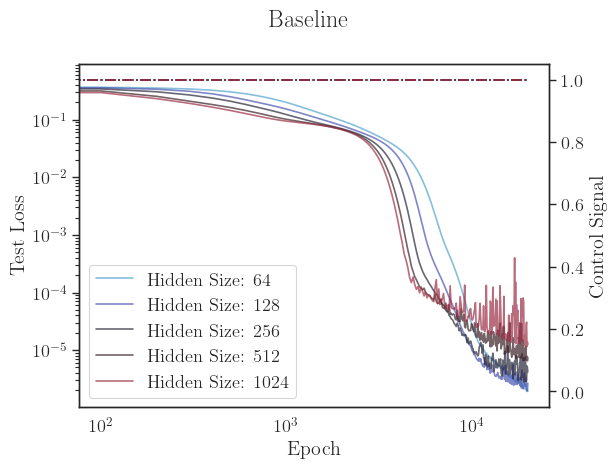

In [113]:
fig, ax1 = plt.subplots()

for i in range(len(hidden_sizes)):
    ax1.plot(
        epochs,
        single_param_baseline["test_loss_mean"].values[i],
        label=f"Hidden Size: {hidden_sizes[i]}",
        alpha=0.7,
    )
    # ax1.fill_between(
    #     epochs,
    #     single_param_baseline["test_loss_mean"].values[i] - single_param_baseline["test_loss_std"].values[i],
    #     single_param_baseline["test_loss_mean"].values[i] + single_param_baseline["test_loss_std"].values[i],
    #     alpha=0.5,
    # )

ax1.set_ylabel("Test Loss")
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
ax1.set_xscale("log")
ax1.legend(loc="best")

# Create a second y-axis for the control signal
ax2 = ax1.twinx()
for i in range(len(hidden_sizes)):
    ax2.plot(
        epochs,
        single_param_baseline["control_mean"].values[i],
        "-.",
        label=f"Hidden Size: {hidden_sizes[i]}",
    )

ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel("Control Signal")
# ax2.legend(loc="upper right")
plt.suptitle("Baseline")
plt.tight_layout()

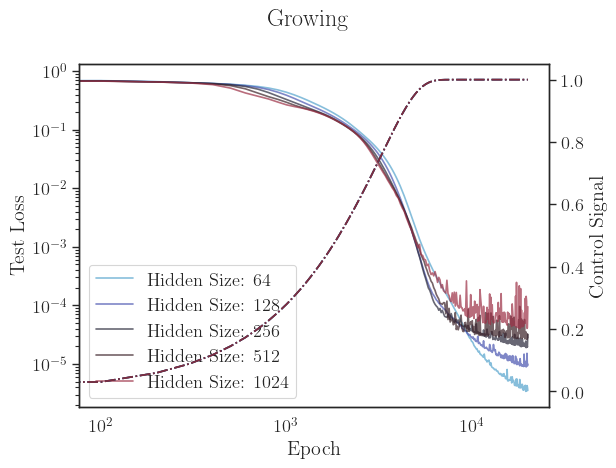

In [114]:
fig, ax1 = plt.subplots()

for i in range(len(hidden_sizes)):
    ax1.plot(
        epochs,
        single_param_growing["test_loss_mean"].values[i],
        label=f"Hidden Size: {hidden_sizes[i]}",
        alpha=0.7,
    )
    # ax1.fill_between(
    #     epochs,
    #     single_param_growing["test_loss_mean"].values[i] - single_param_growing["test_loss_std"].values[i],
    #     single_param_growing["test_loss_mean"].values[i] + single_param_growing["test_loss_std"].values[i],
    #     alpha=0.5,
    # )

ax1.set_ylabel("Test Loss")
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
ax1.set_xscale("log")
ax1.legend(loc="best")

# Create a second y-axis for the control signal
ax2 = ax1.twinx()
for i in range(len(hidden_sizes)):
    ax2.plot(
        epochs,
        single_param_growing["control_mean"].values[i],
        "-.",
        label=f"Hidden Size: {hidden_sizes[i]}",
        alpha=0.7,
    )

ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel("Control Signal")
# ax2.legend(loc="upper right")
plt.suptitle("Growing")
plt.tight_layout()

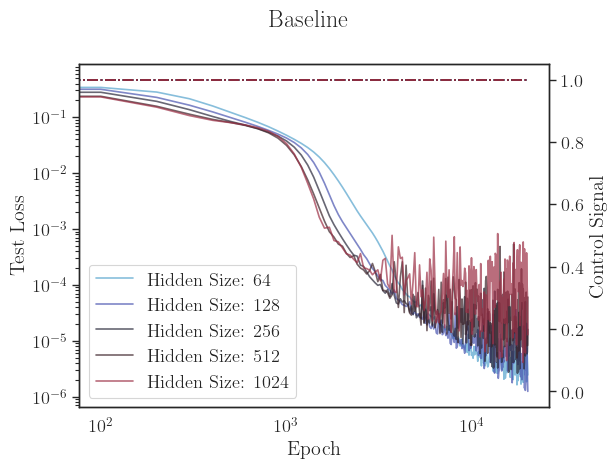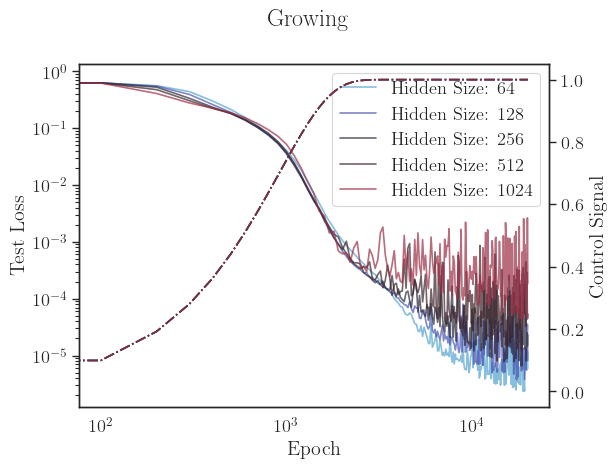

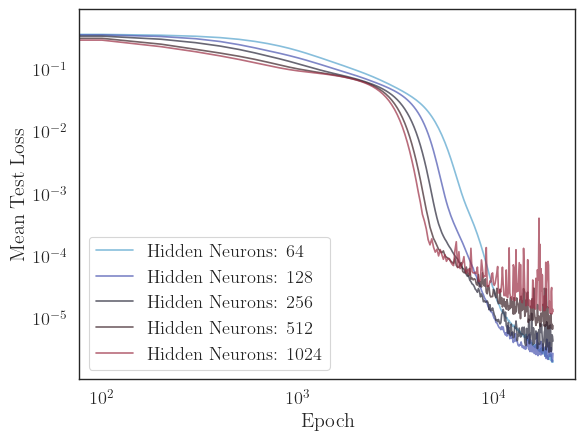

In [115]:
for i, loss in enumerate(single_param_baseline["test_loss_mean"].values):
    plt.plot(epochs, loss, label=f"Hidden Neurons: {hidden_sizes[i]}", alpha=0.7)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Mean Test Loss")
plt.xscale("log")
plt.yscale("log")

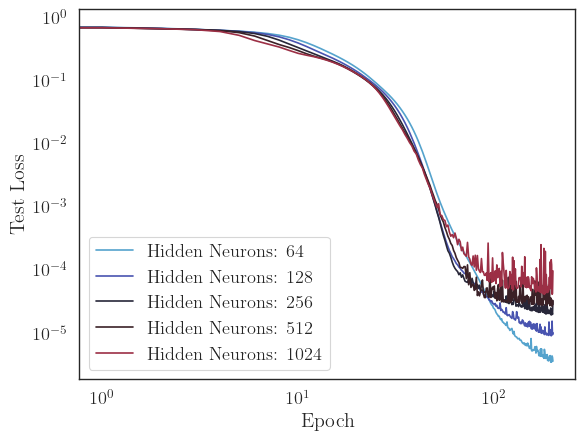

In [116]:
for i, loss in enumerate(single_param_growing["test_loss_mean"].values):
    plt.plot(loss, label=f"Hidden Neurons: {hidden_sizes[i]}")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.xscale("log")
plt.yscale("log")

In [117]:
performance_metric = "test_loss"
parameter = "hidden_size"
epoch_index = 50

In [118]:
x = single_param_df.index.get_level_values(parameter).values
y = np.array(
    [loss[epoch_index] for loss in single_param_df[performance_metric + "_mean"].values]
)
yerr = np.array(
    [loss[epoch_index] for loss in single_param_df[performance_metric + "_std"].values]
)

Text(0, 0.5, 'test_loss')

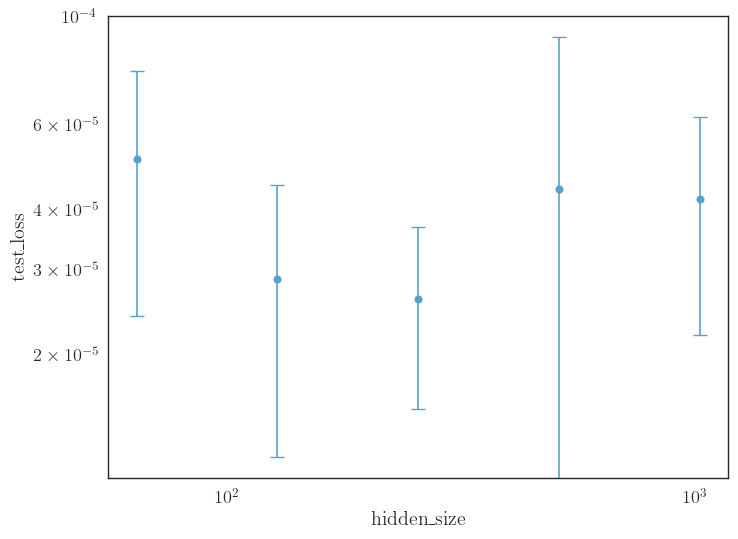

In [119]:
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(parameter)
plt.ylabel(performance_metric)